In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def open_hdf5(file_path):
    """ Open an HDF5 file and return the file object. """
    return h5py.File(file_path, 'r')

hdf5_path = r"/Users/cadenmyers/billingelab/December_extracted_data.h5"


In [44]:
# movie numors
import pandas as pd
# formatting: temp<temperature><magnetic field direction>

cooldown545neg = list(range(121405,121855))
temp550pos = list(range(121016,121076))
temp555pos = list(range(120506,120566))
temp555neg = list(range(122875,122935))
temp560pos = list(range(119996,120055))
temp560neg = list(range(122365,122425))
temp565neg = list(range(121855,121915)) # labeled data
temp565pos = list(range(119486,119546))
temp568pos = list(range(118923,119029))
temp568neg = list(range(121294, 121405))

def correlate_numor_with_time(numor_list):
    time = (np.arange(len(numor_list)) + 1) * 10
    numor_time_df = pd.DataFrame({
        'Numors': numor_list,
        'time (s)': time
    })
    return numor_time_df

cooldown545neg_df = correlate_numor_with_time(cooldown545neg)
temp550pos_df = correlate_numor_with_time(temp550pos)
temp555pos_df = correlate_numor_with_time(temp555pos)
temp555neg_df = correlate_numor_with_time(temp555neg)
temp560pos_df = correlate_numor_with_time(temp560pos)
temp560neg_df = correlate_numor_with_time(temp560neg)
temp565neg_df = correlate_numor_with_time(temp565neg)
temp568pos_df = correlate_numor_with_time(temp568pos)
temp568neg_df = correlate_numor_with_time(temp568neg)

print(temp568neg_df)

     Numors  time (s)
0    121294        10
1    121295        20
2    121296        30
3    121297        40
4    121298        50
..      ...       ...
106  121400      1070
107  121401      1080
108  121402      1090
109  121403      1100
110  121404      1110

[111 rows x 2 columns]


In [7]:
import matplotlib.pyplot as plt

def plot_numor_data(hdf5_file, numor_id):
    """ Plot the data for a specific numor. Ensures only one numor is inputted. """
    # Check if numor_ids is a list and has exactly one item
    if isinstance(numor_id, int):
        numor_id = numor_id
    else:
        return "Error: You can only input a single numor here (e.g [107897])."

    group = hdf5_file[f'Numor{numor_id}']
    q_x = group['q_x (inverse angstrom)'][:]
    q_y = group['q_y (inverse angstrom)'][:]
    intensity = group['intensity (counts per standard monitor)'][:]

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(q_x, q_y, c=intensity, cmap='jet', marker='s', s=40, edgecolors='none')
    cbar = plt.colorbar(scatter)
    #cbar.set_label(zlabel, rotation=270, labelpad=15)  # Adjust label orientation and position
    plt.xlabel('q_x (Å^{-1})')
    plt.ylabel('q_y (Å^{-1})')
    plt.title(f'Intensity Distribution for Numor {numor_id}')
    plt.show()


In [8]:
def get_data_for_ml(hdf5_file, numor_ids):
    """ Extract data and metadata for ML/AI applications for one or multiple numors. """
    all_data = {}
    
    # Ensure numor_ids is a list for single and multiple numor handling
    if not isinstance(numor_ids, list):
        numor_ids = [numor_ids]
    
    for numor_id in numor_ids:
        group = hdf5_file[f'Numor{numor_id}']
        data = {
            'q_x': group['q_x (inverse angstrom)'][:],
            'q_y': group['q_y (inverse angstrom)'][:],
            'intensity': group['intensity (counts per standard monitor)'][:],
            'intensity_err': group['intensity_err (counts per standard monitor)'][:]
        }
        
        # Retrieve and include metadata in the dictionary
        metadata = {attr: group.attrs[attr] for attr in group.attrs}
        data.update(metadata)
        
        # Store data for this numor keyed by its ID
        all_data[numor_id] = data
    
    return all_data

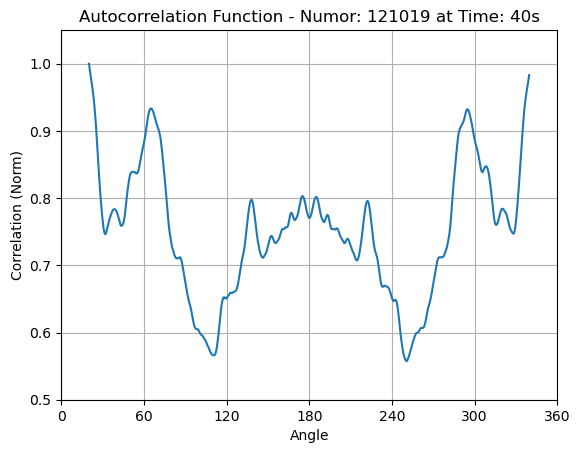

In [56]:
# Autocorrelation function

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

def intensity_values(numor_df, time_stamp, hdf5_path=hdf5_path):
    '''Given a numor_df and time_stamp, this function outputs the intensity of the corresponding numor'''
    numors = numor_df['Numors'].values
    times = numor_df['time (s)'].values
    idx = np.where(times == time_stamp)[0]
    if len(idx) == 0:
        raise ValueError(f"Time stamp {time_stamp} not found in the DataFrame. Time stamp must be a multiple of 10.")
    numor = numors[idx[0]]
    hdf5_file = open_hdf5(hdf5_path)
    numor_data = get_data_for_ml(hdf5_file, numor)
    intensity = numor_data[numor]['intensity']
    return intensity

# print(intensity_values(temp550pos_df, 10))

def single_autocorrelation_function(numor_df, time_stamp, hdf5_path=hdf5_path):
    intensity = intensity_values(numor_df, time_stamp, hdf5_path)
    angle_range = np.arange(20, 340, 0.5)
    autocorr_vals = []
    
    idx = np.where(numor_df['time (s)'].values == time_stamp)[0][0]
    numor = numor_df.iloc[idx]['Numors']
    
    for angle in angle_range:
        rotated_intensity = rotate(intensity, angle=angle, reshape=False)
        autocorr = rotated_intensity * intensity
        autocorr_sum = np.sum(autocorr)
        autocorr_vals.append(autocorr_sum)
    
    autocorr_vals = np.array(autocorr_vals)
    autocorr_norm = autocorr_vals / np.max(autocorr_vals)
    
    plt.plot(angle_range, autocorr_norm)
    plt.xlabel('Angle')
    plt.ylabel("Correlation (Norm)")
    plt.ylim(0.5, 1.05)
    plt.xticks(np.arange(0, 361, 60))
    plt.title(f'Autocorrelation Function - Numor: {numor} at Time: {time_stamp}s')
    plt.grid(True)
    plt.show()
    return 

single_autocorrelation_function(temp550pos_df, 40)



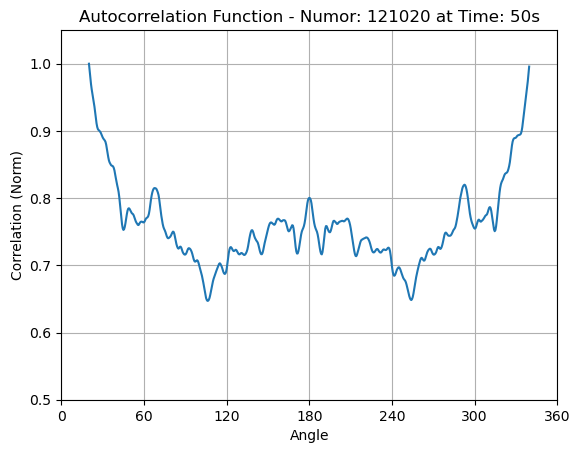

In [68]:
# autocorrelation functions
def autocorrelation_functions(numor_df, start_time, end_time):
    '''outputs the autocorrelation function over a time range'''
    for time in (np.arange(start_time, end_time+10, 10)):
        single_autocorrelation_function(numor_df, time)
    return

autocorrelation_functions(temp550pos_df, 50, 50)